In [1]:
import pygraphviz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch

In [2]:
def get_adj_matrix(dot_file_path):
    G = pygraphviz.AGraph()
    G.read(dot_file_path)
    adj_matrix = []
    for node in G.nodes():
        # get adjacency values per node (*1) turns Bool to value 1 or 0
        row = [G.has_edge(node, other_node)*1 for other_node in G.nodes()]
        adj_matrix.append(row)
    return np.array(adj_matrix)

def get_adj_list(dot_file_path):
    G = pygraphviz.AGraph()
    G.read(dot_file_path)
    adj_list = {}
    for node in G.nodes():
        adj_list[node] = [other_node for other_node in G.nodes() if G.has_edge(node, other_node)]
    return adj_list

In [3]:
dot_file_path = "../Datasets/LeagueNetwork.dot"

In [4]:
adj_matrix = get_adj_matrix(dot_file_path)
adj_list = get_adj_list(dot_file_path)

In [6]:
# N nodes
N = len(adj_matrix)


In [7]:
plot_graph(adj_matrix=adj_matrix,custom_xlim=(0,100),custom_ylim=(0,100),layout_type='circular', axis=False)

NameError: name 'plot_graph' is not defined

In [8]:
class Node:
    def __init__(self, _id, number, color='green'):
        self.id = _id
        self.number = number
        self.in_neighbours = []
        self.out_neighbours = []
        self.circle = Circle(xy=np.zeros(2), radius = .1, color = color, alpha=.5)

    def add_out_neighbour(self, neighbour, weight=1):
        if neighbour not in self.out_neighbours:
            self.out_neighbours.append((neighbour, weight))

    def add_in_neighbour(self, neighbour, weight=1):
        if neighbour not in self.in_neighbours:
            self.in_neighbours.append((neighbour, weight))

    def show_label(self, ax):
        ax.text(*self.circle.center, str(self.id), size=6, ha='center', va='baseline', alpha=.5)

class TreeNode(Node):
    def __init__(self, label, tree_dict=None):
        super().__init__(label)
        self.children = set()
        self.parent = None
        self.non_tree_neighbours = []
        self.width = None
        self.level = None
        self.height = None
        self.x_y_ratio = None

    @classmethod
    def build_tree_from_dict(cls, tree_dict):
        node_instances = {}

        def build_tree_helper(label):
            if label not in node_instances:
                node_instances[label] = TreeNode(label)

            node = node_instances[label]

            if label in tree_dict:
                for child, weight in tree_dict[label]:
                    child_node = build_tree_helper(child.id)
                    node.add_child(child_node, weight)

            return node

        root_label = next(iter(tree_dict))
        root_node = build_tree_helper(root_label)

        return root_node

    def add_child(self, child, weight=1):
        child.parent = self
        self.children.add((child, weight))

    def get_height(self):
        if not self.children:
            return 0
        self.height = 1 + max([child[0].get_height() for child in self.children])
        return self.height

    def compute_drawing_params(self):
        self.calculate_width()
        self.get_height()
        self.x_y_ratio = max((self.width//2) // self.height, self.height // (self.width//2))

    def get_level(self):
        self.level = 0
        current_parent = self.parent
        while current_parent:
            current_parent = current_parent.parent
            self.level += 1
        return self.level

    def calculate_width(self):
        self.width = 0
        children_widths = [child[0].calculate_width() for child in self.children]
        self.width = 1 + sum(children_widths)
        return self.width

    def compute_coordinates(self, x, y, x_y_ratio=1):
        self.coordinates = (x, y)
        if self.children:
            total_children_width = sum([child[0].width for child in self.children])
            starting_x = x - total_children_width // 2
            for child, _ in self.children:
                child_x = starting_x + child.width // 2
                child.compute_coordinates(child_x, 0 - child.get_level() * x_y_ratio, x_y_ratio)
                starting_x += child.width

    def draw_tree(self, labels=True, non_tree_edges=False):
        self.compute_drawing_params()
        self.compute_coordinates(0, 0, self.x_y_ratio)
        fig = plt.figure()
        ax = fig.gca()
        plt.axis(False)

        def draw_patch(node, ax):
            ax.add_patch(Circle(xy=node.coordinates, radius=0.5, color='green', alpha=0.3))
            if labels:
                plt.text(*node.coordinates, str(node.id), size=6, ha='center', va='baseline', alpha=0.5)
            if node.children:
                for child, _ in node.children:
                    ax.add_patch(ConnectionPatch(node.coordinates, child.coordinates, 'data', lw=0.5, color='grey'))
                    draw_patch(child, ax)
            if non_tree_edges:
                for nt_neighbour_label in node.non_tree_neighbours:
                    nt_neighbour_node = self.find_tree_node(nt_neighbour_label)
                    ax.add_patch(ConnectionPatch(node.coordinates, nt_neighbour_node.coordinates, 'data', lw=0.1, color='blue', linestyle=":"))

        draw_patch(self, ax)

        margin = 2
        x_lim = self.width // 2
        ax.set_xlim((-x_lim - margin, x_lim + margin))
        ax.set_ylim((-self.height * self.x_y_ratio - margin, 0 + margin))
        plt.grid(which='minor', axis='y', linewidth=0.5, linestyle=':')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)
        ax.tick_params(tick1On=False, which='both')
        ax.minorticks_on()
        plt.show()
        return fig

    def find_tree_node(self, label):
        queue = [self]
        while queue:
            current_node = queue.pop(0)
            if current_node.id == label:
                return current_node
            queue.extend([child[0] for child in current_node.children])

class Edge:
    def __init__(self, n1, n2, weight=1, directed=False):
        self.directed = directed
        self.node1, self.node2 = n1, n2
        self.circle1 = n1.circle
        self.circle2 = n2.circle
        self.inverted = False
        self.weight = weight
        if self.directed:
            if self.inverted:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='red', arrowstyle="->")
            else:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='red', arrowstyle="->")
        else:
            self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='grey')

    def update_line(self, ax1=None, ax2=None, color="grey", coordsA='data', coordsB='data'):
        if self.directed:
            if self.inverted:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color, arrowstyle="->")
            else:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color, arrowstyle="->")
        else:
            self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4)


In [9]:

class Graph:
    def __init__(self, incoming_dot_file=None, directed = False, subgraphs = False, a_subgraph = False, selected_subgraphs=None,weight_name="weight"):
        # directed graph
        self.directed = directed
        self.feedback_set = set()
        # graph nodes and edges
        self.nodes, self.edges = {}, {}
        if incoming_dot_file:
            self.load_graph(incoming_dot_file, subgraphs=subgraphs, selected_subgraphs=selected_subgraphs, weight_name=weight_name)

        # graph figure for visualisation
        self.fig = None if a_subgraph or subgraphs else plt.figure(figsize=(7,7))
        self.ax =  None if a_subgraph or subgraphs else self.fig.gca()
        self.axes = []
        self.min_max_x = np.array([0,1])
        self.min_max_y = np.array([0,1])

        # graph traversals
        self.dfs_order = []
        self.bfs_order= []
        # trees
        self.dfs_tree = {}
        self.bfs_tree = {}

    def load_graph(self, dot_file_path, subgraphs=False, selected_subgraphs=None,weight_name="weight"):
        G = pygraphviz.AGraph()
        G.read(dot_file_path)

        if subgraphs:
            self.subgraphs = {}
            for subgraph in G.subgraphs():
                if selected_subgraphs:
                    subgraph_name = subgraph.name
                    if subgraph_name in selected_subgraphs:
                        self.subgraphs[subgraph_name] = Graph(a_subgraph=True)

                        # nodes
                        for graphviz_node in subgraph.nodes():
                            node_id = graphviz_node.get_name()
                            node = Node(_id=node_id)
                            self.subgraphs[subgraph_name].nodes[node_id] = node
                else:
                    subgraph_name = subgraph.name
                    self.subgraphs[subgraph_name] = Graph(a_subgraph=True)
                    # nodes
                    for graphviz_node in subgraph.nodes():
                        node_id = graphviz_node.get_name()
                        node = Node(_id=node_id)
                        self.subgraphs[subgraph_name].nodes[node_id] = node

            # edges
            for graphviz_edge in G.edges():
                node1_id = graphviz_edge[0]
                node2_id = graphviz_edge[1]
                subgraph_name_1 = self.find_subgraph_for_node(node1_id)
                subgraph_name_2 = self.find_subgraph_for_node(node2_id)
                if selected_subgraphs:
                    if subgraph_name_1 in selected_subgraphs and subgraph_name_2 in selected_subgraphs:
                        edge = Edge(self.subgraphs[subgraph_name_1].nodes[node1_id], self.subgraphs[subgraph_name_2].nodes[node2_id],directed=self.directed)
                        self.edges[(node1_id, node2_id)] = edge
                else:
                    edge = Edge(self.subgraphs[subgraph_name_1].nodes[node1_id], self.subgraphs[subgraph_name_2].nodes[node2_id], directed=self.directed)
                    self.edges[(node1_id, node2_id)] = edge

        else:
            # nodes
            for i, graphviz_node in enumerate(G.nodes()):
                node = Node(_id=graphviz_node.get_name(),number=i)
                self.nodes[node.id] = node

            # edges
            for graphviz_edge in G.edges():
                node1_id = graphviz_edge[0]
                node2_id = graphviz_edge[1]

                weight = graphviz_edge.attr[weight_name] if weight_name in graphviz_edge.attr else None

                self.nodes[node1_id].add_out_neighbour(self.nodes[node2_id])
                self.nodes[node2_id].add_in_neighbour(self.nodes[node1_id])
                if self.directed:
                    edge = Edge(self.nodes[node1_id], self.nodes[node2_id], weight=weight, directed=True)
                else:
                    edge = Edge(self.nodes[node1_id], self.nodes[node2_id], weight=weight)
                self.edges[(node1_id, node2_id)] = edge

    def find_subgraph_for_node(self, node_id):
        for subgraph_name, subgraph in self.subgraphs.items():
            if node_id in subgraph.nodes:
                return subgraph_name

    def add_node(self, node_id):
        self.nodes[node_id] = Node(node_id)

    def return_fig(self,labels=True,axis=False,subgraphs=False, title=None):
        print("Updating Figure")
        if subgraphs:
            for name, subgraph in self.subgraphs.items():
                subgraph.return_fig(title=name)
        else:
            node_radius = min(.1,(self.min_max_x[1] - self.min_max_x[0]) / (5 * math.sqrt(len(self.nodes))))

            for edge in self.edges.values():
                edge.update_line()
                self.ax.add_patch(edge.line)

            for node in self.nodes.values():
                node.circle.radius = node_radius
                self.ax.add_patch(node.circle)
                if labels:
                    node.show_label(self.ax)


            x_lim = self.min_max_x + np.array([-node_radius,node_radius])
            y_lim = self.min_max_y + np.array([-node_radius,node_radius])
            self.ax.set_xlim(x_lim)
            self.ax.set_ylim(y_lim)
            self.ax.set_title(title)

            plt.axis(axis)

            return self.fig

    def update_ax(self, labels=True, axis=False, title=None, ax = None):
        print("Updating Figure")
        node_radius = min(.1, (self.min_max_x[1] - self.min_max_x[0]) / (5 * math.sqrt(len(self.nodes))))


        for node in self.nodes.values():
            node.circle.radius = node_radius
            ax.add_patch(node.circle)
            if labels:
                node.show_label(ax)
        x_lim = self.min_max_x + np.array([-(node_radius+.1), node_radius+.1])
        y_lim = self.min_max_y + np.array([-(node_radius+.1), node_radius+.1])
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title(title)

        ax.axis(axis)

    def return_subplots(self, labels=True, axis=False, title=None):

        num_subgraphs = len(self.subgraphs)
        num_cols = int(np.ceil(np.sqrt(num_subgraphs)))  # Number of columns based on square root of num_subgraphs

        # Adjust num_rows to ensure that num_cols * num_rows is greater than or equal to num_subgraphs
        num_rows = (num_subgraphs + num_cols - 1) // num_cols

        self.fig, self.axes = plt.subplots(num_rows, num_cols, figsize=(10, 8), sharex=True, sharey=True)

        for (name, subgraph), ax_sub in zip(self.subgraphs.items(), self.axes.flatten()):
            subgraph.update_ax(labels=labels, axis=axis, title=name, ax=ax_sub)
            ax_sub.set_aspect('equal')
             # Draw bounding box around the subgraph
            min_x, max_x = ax_sub.get_xlim()
            min_y, max_y = ax_sub.get_ylim()
            bbox = Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor="green", facecolor='none')
            ax_sub.add_patch(bbox)

            for edge in self.edges.values():
                node1_id, node2_id = edge.node1.id, edge.node2.id
                subgraph1 = self.find_subgraph_containing_node(node1_id)
                subgraph2 = self.find_subgraph_containing_node(node2_id)
                if subgraph1 is not None and subgraph2 is not None and subgraph1 != subgraph2:
                    # Draw connection between subgraphs
                    ax1 = self.axes.flatten()[list(self.subgraphs.keys()).index(subgraph1)]
                    ax2 = self.axes.flatten()[list(self.subgraphs.keys()).index(subgraph2)]
                    edge.update_line(ax1=ax1,ax2=ax2,color="red",coordsA='data',coordsB='data')
                    ax_sub.add_patch(edge.line)
                else:
                    edge.update_line()
                    ax=self.axes.flatten()[list(self.subgraphs.keys()).index(subgraph1)]
                    ax.add_patch(edge.line)
        #plt.tight_layout()
        plt.suptitle(title, y=1.02)
        plt.show()

    def find_subgraph_containing_node(self, node_id):
        for name, subgraph in self.subgraphs.items():
            if node_id in subgraph.nodes:
                return name
        return None

    def circular_layout(self, center=(.5,.5), radius=.5, subgraphs=False):
        if subgraphs:
            for subgraph in self.subgraphs.values():
                subgraph.circular_layout()
        N = len(self.nodes)
        cx, cy = center
        i = 0
        for node in self.nodes.values():
            angle = 2* np.pi * i / N
            x = cx + radius * np.cos(angle)
            y = cy + radius * np.sin(angle)
            node.circle.center = np.array([x,y])
            i += 1

    def random_layout(self, x_range=(0.0, 1.0), y_range=(0.0, 1.0), subgraphs=False):
        if subgraphs:
            for subgraph in self.subgraphs.values():
                subgraph.random_layout()
        for node in self.nodes.values():
            x = np.random.uniform(x_range[0], x_range[1])
            y = np.random.uniform(y_range[0], y_range[1])
            node.circle.center = np.array([x,y])

    def dfs(self, root):
        visited = set()
        self.dfs_order = []
        self.dfs_tree = {root: []}
        def dfs_recursive(node_id):
            visited.add(node_id)
            self.dfs_order.append(node_id)
            for neighbour in self.nodes[node_id].out_neighbours:
                if neighbour.id not in visited:
                    self.dfs_tree[node_id].append(neighbour)
                    self.dfs_tree[neighbour.id] = []
                    dfs_recursive(neighbour.id)
        dfs_recursive(root)

    def bfs(self, root):
        visited = set()
        self.bfs_order = []
        self.bfs_tree = {root: []}
        queue = deque([root])

        while queue:
            node_id = queue.popleft()
            if node_id in visited:
                continue
            visited.add(node_id)
            self.bfs_order.append(node_id)

            for neighbour in self.nodes[node_id].out_neighbours:
                if neighbour.id not in visited:
                    self.bfs_tree[node_id].append(neighbour.id)
                    self.bfs_tree[neighbour] = []
                    queue.append(neighbour.id)

    def force_directed_graph(self, embedder_type="Eades", K=500, epsilon=1e-4, delta=.1, c=.9,c_rep=1,c_spring=2, subgraphs=False):
        print("force directed graph computation")
        l = c * 1  # ideal edge length

        def repulsive_force(distance, diff):
            if embedder_type == "Fruchterman & Reingold":
                return (l**2 / distance) * diff
            if embedder_type == "Eades":
                return c_rep * diff / (distance**2)

        def attractive_force(distance, diff):
            if embedder_type == "Fruchterman & Reingold":
                return (distance**2 / l) * diff
            if embedder_type == "Eades":
                return c_spring * np.log(distance / l) * diff

        if subgraphs:
            for subgraph in self.subgraphs.values():
                    subgraph.force_directed_graph()

        for _ in range(K):
            displacement = {v: np.zeros(2) for v in self.nodes.keys()}

            # calculate repulsive forces
            for key_u, u in self.nodes.items():
                for v in self.nodes.values():
                    diff = u.circle.center - v.circle.center
                    distance = np.linalg.norm(diff)
                    if distance > 0:
                        disp = repulsive_force(distance, diff)
                        displacement[key_u] += disp

            # calculate attractive forces
            for key_u, u in self.nodes.items():
                for key_v, v in self.nodes.items():
                    diff = u.circle.center - v.circle.center
                    distance = np.linalg.norm(diff)
                    if distance > 0:
                        disp = attractive_force(distance, diff)
                        displacement[key_u] -= disp
                        displacement[key_v] += disp

            # update positions
            for key_v, v in self.nodes.items():
                length = np.linalg.norm(displacement[key_v])
                if length > 0:
                    # displacement vector is normalized
                    v.circle.center += delta * displacement[key_v] / length
                    self.min_max_x = np.array([min(v.circle.center[0],self.min_max_x[0]),
                                               max(v.circle.center[0],self.min_max_x[1])])
                    self.min_max_y = np.array([min(v.circle.center[1],self.min_max_y[0]),
                                               max(v.circle.center[1],self.min_max_y[1])])

            max_displacement = max(np.linalg.norm(disp) for disp in displacement.values()) if displacement.values() else 0

            if max_displacement < epsilon:
                break

    def remove_cycles(self):
        order = []
        self.feedback_set = set()
        for node_id in sorted(self.nodes.keys(), key=lambda x: int(x)):
            node = self.nodes[node_id]
            order.append(node_id)
            for neighbour in node.out_neighbours:
                if neighbour.id in order:
                    # inverse edge direction in node
                    node.out_neighbours.remove(neighbour)
                    node.in_neighbours.append(neighbour)
                    # inverse edge direction in neighbour
                    neighbour.in_neighbours.remove(node)
                    neighbour.out_neighbours.append(node)
                    # inverse edge
                    self.edges[(node_id,neighbour.id)].invert()
                    self.feedback_set.add(self.edges[(node_id,neighbour.id)])

    def heuristic_with_guarantees(self):
        edges_to_reverse = set()

        while len(self.nodes) > 0:
            sinks = [node for node in self.nodes.values() if len(node.in_neighbours) > 0 and len(node.out_neighbours) == 0]
            for sink in sinks:
                for in_n in sink.in_neighbours:
                    edges_to_reverse.add((in_n, sink))
                self.remove_node(sink)

            isolated_nodes = [isolate for isolate in self.nodes.values() if len(isolate.in_neighbours) + len(isolate.out_neighbours) == 0]
            for isolate in isolated_nodes:
                self.remove_node(isolate)

            sources = [node for node in self.nodes.values() if len(node.out_neighbours) > 0 and len(node.in_neighbours) == 0]
            for source in sources:
                for out_n in source.out_neighbours:
                    edges_to_reverse.add((out_n, source))
                self.remove_node(source)

            # If graph is non-empty, select a node with max |N_outgoing| - |N_incoming|
            if len(self.nodes) > 0:
                node = max(self.nodes.values(), key=lambda node: len(node.in_neighbours) - len(node.out_neighbours))
                for out_n in node.out_neighbours:
                    edges_to_reverse.add((out_n, node))
                self.remove_node(node)

        return edges_to_reverse

    def remove_node(self, node):
        for neighbour in node.out_neighbours:
            neighbour.in_neighbours.remove(node)
        for neighbour in node.in_neighbours:
            neighbour.out_neighbours.remove(node)
        del self.nodes[node.id]

    def has_cycle(self):
        visited = set()
        recursion_stack = set()

        def dfs(node_id):
            if node_id in recursion_stack:
                return True
            if node_id in visited:
                return False
            visited.add(node_id)
            recursion_stack.add(node_id)
            for neighbour in self.nodes[node_id].out_neighbours:
                if dfs(neighbour.id):
                    return True
            recursion_stack.remove(node_id)
            return False

        for node in self.nodes:
            if dfs(node):
                return True
        return False

    def topological_sort(self):
        # Dictionary to store in-degrees of nodes
        in_degrees = {node_id: 0 for node_id in self.nodes}

        # Calculate in-degrees of nodes
        for node_id, node in self.nodes.items():
            for neighbour in node.out_neighbours:
                in_degrees[neighbour.id] += 1

        # Queue for nodes with no incoming edges
        queue = deque([node_id for node_id, in_degree in in_degrees.items() if in_degree == 0])

        # Topologically sorted nodes
        sorted_nodes = []

        # Perform topological sorting
        while queue:
            node_id = queue.popleft()
            sorted_nodes.append(node_id)

            # Reduce in-degree of neighbors
            for neighbour in self.nodes[node_id].out_neighbours:
                in_degrees[neighbour.id] -= 1

                # Add neighbor to queue if its in-degree becomes 0
                if in_degrees[neighbour.id] == 0:
                    queue.append(neighbour.id)

        return sorted_nodes

    def assign_layers(self):
        # Perform topological sort to get node order
        node_order = self.topological_sort()

        # Dictionary to store layer assignments
        layer_assignments = {node_id: 0 for node_id in self.nodes}

        # Assign layers based on topological order
        for node_id in node_order:
            node = self.nodes[node_id]
            if node.in_neighbours:
                max_predecessor_layer = max(layer_assignments[predecessor.id] for predecessor in node.in_neighbours)
            else:
                max_predecessor_layer = 0
            layer_assignments[node_id] = max_predecessor_layer + 1

        # Update layer attribute of nodes
        for node_id, layer in layer_assignments.items():
            self.nodes[node_id].layer = layer

        return layer_assignments

    def distances_matrix(self):
        N = len(self.nodes)
        D = np.ones((N,N)) * 10000
        numbered_nodes = {node.number:node for node in self.nodes.values()}
        numbered_edges = {(edge.node1.number, edge.node2.number): edge for edge in self.edges.values()}
        for (i,j), edge in numbered_edges.items():
            D[i,j] = int(edge.weight) if edge.weight else 1 # if no weights give path vlalue
            D[j, i] = D[i,j] # symmetry!

        #self loop
        for i in range(N):
            D[i, i] = 0

        for k, knode in numbered_nodes.items():
            for i, inode in numbered_nodes.items():
                for j, jnode in numbered_nodes.items():
                    if D[i,j] > D[i,k] + D[k,j]:
                        D[i,j] = D[i,k] + D[k,j]
                        D[j, i] = D[i, j] # symmetry!
        return D


def layer_assignments_to_tree(layer_assignments):
    # Initialize tree dictionary
    tree_dict = {}

    # Group nodes by layer
    nodes_by_layer = {}
    for node_id, layer in layer_assignments.items():
        if layer not in nodes_by_layer:
            nodes_by_layer[layer] = []
        nodes_by_layer[layer].append(node_id)

    # Create tree dictionary
    for layer, nodes in nodes_by_layer.items():
        if layer not in tree_dict:
            tree_dict[layer] = []
        for node_id in nodes:
            node_dict = {"id": node_id, "children": []}
            if layer > 0:
                # Find parent nodes in the previous layer
                parent_nodes = [parent_id for parent_id, parent_layer in layer_assignments.items() if parent_layer == layer - 1]
                # Connect the node to its parent nodes
                for parent_id in parent_nodes:
                    tree_dict[layer - 1].append(node_dict)
            else:
                # If it's the root layer, add directly to the tree dictionary
                tree_dict[layer].append(node_dict)

    return tree_dict

def ax_to_fig_coords(ax, xy):

    mytrans = ax.transData + ax.figure.transFigure.inverted()
    trans = mytrans.transform([xy])
    fig_x, fig_y = trans[0]

    return fig_x, fig_y


In [10]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

In [14]:
dot_file_path = "../Datasets/LesMiserables.dot"

In [15]:
g = Graph(incoming_dot_file=dot_file_path)
plt.close()
D = g.distances_matrix()
np.allclose(D, D.T)


True

In [16]:
D

array([[ 0.,  1.,  9., ...,  9.,  9., 11.],
       [ 1.,  0.,  8., ...,  8.,  8., 10.],
       [ 9.,  8.,  0., ...,  6.,  6.,  8.],
       ...,
       [ 9.,  8.,  6., ...,  0.,  5.,  5.],
       [ 9.,  8.,  6., ...,  5.,  0.,  8.],
       [11., 10.,  8., ...,  5.,  8.,  0.]])

In [17]:
mds = MDS(n_components=2, dissimilarity='precomputed')
mds_embedding = mds.fit_transform(D)

isomap = Isomap(n_components=2, metric='precomputed')
isomap_embedding = isomap.fit_transform(abs(D))

tsne = tsne = TSNE(n_components=2, metric='precomputed',perplexity=4)
tsne_embedding = tsne.fit_transform(abs(D))

/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 

/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/sklearn/manifold/_mds.py:512: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


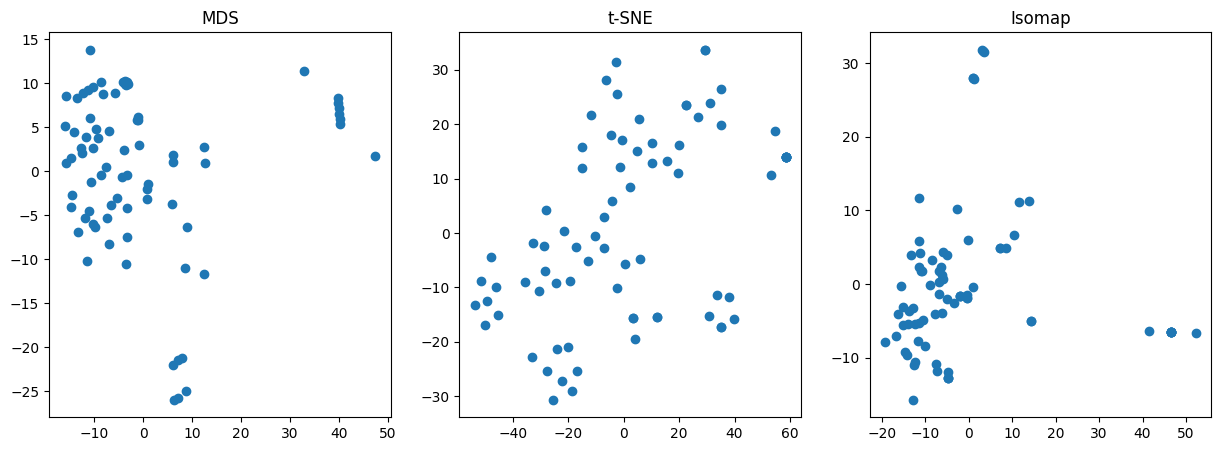

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# MDS with adjusted parameters
mds = MDS(n_components=2, dissimilarity="euclidean", random_state=6)
results = mds.fit(D)
coords = results.embedding_
axs[0].scatter(coords[:, 0], coords[:, 1], marker = 'o')
axs[0].set_title('MDS')

# t-SNE with adjusted parameters
tsne = TSNE(n_components=2, perplexity=10, learning_rate=1, random_state=0, metric='euclidean')
Y = tsne.fit_transform(D)
axs[1].scatter(Y[:, 0], Y[:, 1], marker = 'o')
axs[1].set_title('t-SNE')

# ISOMAP with adjusted parameters
iso = Isomap(n_neighbors=15, n_components=2)
iso.fit(D)
manifold_2Da = iso.transform(D)
axs[2].scatter(manifold_2Da[:, 0], manifold_2Da[:, 1], marker = 'o')
axs[2].set_title('Isomap')

plt.show()